In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [18]:
############################################
sweep_root = "../../results/faithfulness_baselines"
model_name = "gptj"
############################################

results_file = f"{sweep_root}/{model_name}.json"

with open(results_file, "r") as f:
    results_raw = json.load(f)

In [19]:
results_formatted = {}
for relation_results in results_raw:
    result = {k: v for k, v in relation_results.items() if k != "trials"}
    result["recall"] = {}
    for trial_result in relation_results["trials"]:
        method_keys = [k for k in trial_result.keys() if k not in ["icl_prompt", "train"]]
        for method_key in method_keys:
            if method_key not in result["recall"]:
                result["recall"][method_key] = []
            result["recall"][method_key].append(trial_result[method_key]["recall"])
    for key in method_keys:
        result["recall"][key] = np.array(result["recall"][key]).mean(axis = 0)
    
    results_formatted[relation_results["relation_name"]] = result

In [21]:
results_formatted.keys()

dict_keys(['country language', 'person university', 'country largest city', 'country capital city', 'verb past tense', 'superhero archnemesis', 'adjective comparative', 'occupation gender', 'adjective antonym', 'adjective superlative', 'occupation age', 'country currency', 'person plays instrument', 'word sentiment', 'company CEO', 'city in country', 'president election year', 'task done by tool', 'food from country', 'person occupation', 'pokemon evolution', 'president birth year', 'work location', 'superhero person', 'person mother', 'person lead singer of band', 'name gender', 'star constellation name', 'object superclass', 'name birthplace', 'word first letter', 'person sport position', 'plays pro sport', 'product by company', 'substance phase of matter', 'company hq', 'task person type', 'landmark on continent', 'person native language', 'landmark in country'])

In [29]:
results_formatted['country language']

{'relation_name': 'country language',
 'h_layer': 0,
 'beta': 0.31666667262713116,
 'known_samples': 21,
 'total_samples': 24,
 'prompt_template': 'People in {} speak',
 'recall': {'zero_shot': array([0.25      , 0.3125    , 0.39583333, 0.41666667, 0.4375    ,
         0.5       , 0.58333333, 0.625     , 0.64583333, 0.66666667]),
  'logit_lens': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'corner': array([0.0625    , 0.20833333, 0.35416667, 0.45833333, 0.52083333,
         0.60416667, 0.6875    , 0.6875    , 0.75      , 0.75      ]),
  'learned_linear': array([0.08333333, 0.39583333, 0.5       , 0.52083333, 0.54166667,
         0.54166667, 0.58333333, 0.58333333, 0.58333333, 0.60416667]),
  'icl_mean_emb': array([0.45833333, 0.47916667, 0.52083333, 0.66666667, 0.6875    ,
         0.72916667, 0.77083333, 0.83333333, 0.83333333, 0.83333333]),
  'icl_mean': array([0.95833333, 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1

In [26]:
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [37]:
from typing import Literal
property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type"


performance_category_wise = {}
for relation_name in results_formatted:
    property_value = relations_by_name[relation_name].properties.__dict__[property_key]
    result = results_formatted[relation_name]
    if property_value not in performance_category_wise:
        performance_category_wise[property_value] = {}
    for method in result["recall"]:
        if method not in performance_category_wise[property_value]:
            performance_category_wise[property_value][method] = []
        performance_category_wise[property_value][method].append(result["recall"][method])
    

for property_value in performance_category_wise:
    for method in performance_category_wise[property_value]:
        performance_category_wise[property_value][method] = np.array(performance_category_wise[property_value][method]).mean(axis = 0)

In [38]:
performance_category_wise

{'factual': {'zero_shot': array([0.24071529, 0.31710804, 0.36917051, 0.41015179, 0.44069851,
         0.46021968, 0.48644965, 0.50341552, 0.51525702, 0.52821025]),
  'logit_lens': array([0.03743625, 0.05208311, 0.0671872 , 0.07711471, 0.08848843,
         0.09650941, 0.10591984, 0.11659117, 0.12187511, 0.12975155]),
  'corner': array([0.32433077, 0.41818713, 0.46451733, 0.55482275, 0.58490836,
         0.61174451, 0.63960036, 0.65648598, 0.68231596, 0.69668531]),
  'learned_linear': array([0.1028546 , 0.16677938, 0.20824542, 0.23989746, 0.27011001,
         0.28870131, 0.31011443, 0.32224437, 0.3370719 , 0.35210644]),
  'icl_mean_emb': array([0.18286647, 0.25420276, 0.29626415, 0.34713526, 0.38461287,
         0.41730449, 0.44404586, 0.46881364, 0.48399904, 0.50601468]),
  'icl_mean': array([0.62882791, 0.74837741, 0.79277557, 0.82058085, 0.84389697,
         0.85938608, 0.86926158, 0.87465967, 0.88335629, 0.89030413])},
 'linguistic': {'zero_shot': array([0.23594951, 0.32999043, 0.389

In [54]:
def plot_categorywise(canvas, result, title, recall_upto = 3):
    bar_width = 0.225
    for r in range(recall_upto):
        recalls = [result[method][r] for method in result]
        canvas.bar(np.arange(len(recalls)) + r * bar_width, recalls, width = bar_width, label = f"Recall@{r + 1}")
    
    canvas.set_ylim(0, 1)
    canvas.set_title(title.capitalize())
    canvas.set_xticks(np.arange(len(result)) + bar_width)
    canvas.set_xticklabels([method.capitalize() for method in result], rotation = 45)
        

/tmp/ipykernel_269221/3286450834.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


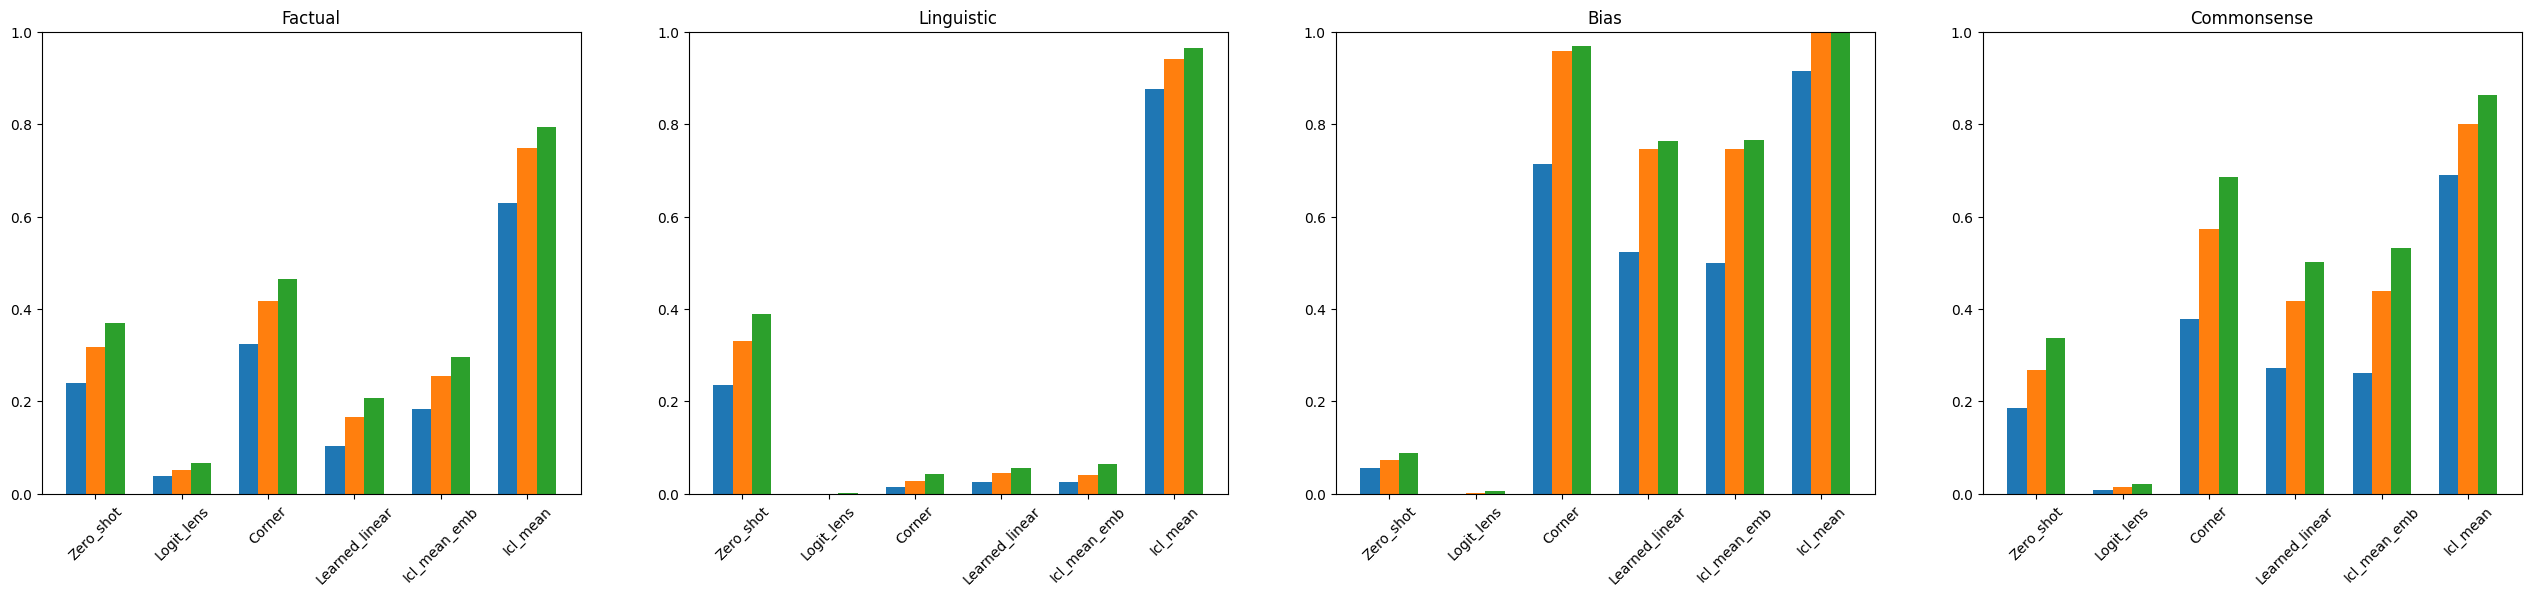

In [56]:
n_subplots = len(performance_category_wise)
ncols=n_subplots
nrows=1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0
for i, (category, result) in enumerate(performance_category_wise.items()):
    plot_categorywise(canvas = axes[ax_row][ax_col], result = result, title = category)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
fig.show()

In [51]:
len(result)

6